# 1. Importing Packages

In [154]:
# importing shit
import yfinance as yf
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt

In [329]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, GridSearchCV

In [105]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29413 sha256=0d7b8a012c90fa20b1c284a977ffd3a0433d8f64c8aeacb23c837a8547212d14
  Stored in directory: /Users/eshanaagarwal/Library/Caches/pip/wheels/b1/8e/55/64e87f8cc064571b0096ff2e5f32a4d29e444705f33b361a3d
Successfully built ta
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [62]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/eshanaagarwal/nltk_data...


True

In [155]:
import ta

# 2. Preparing Data

**2.a Get Stock Data**

<AxesSubplot:xlabel='Date'>

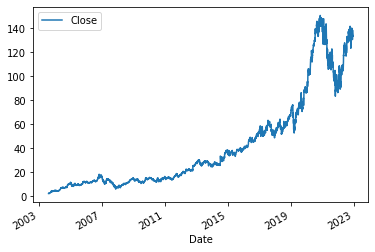

In [125]:
data = yf.Ticker("GOOG")
data = data.history(period = "max")
data.plot.line(y = "Close", use_index = True) 

In [126]:
data["Adjusted Close"] = data["Close"] - data["Dividends"]
del data["Dividends"]
del data["Stock Splits"]
data["Tomorrow"] = data["Adjusted Close"].shift(-1)
data["Target"] = (data["Tomorrow"] > data["Adjusted Close"]).astype(int)

In [127]:
data = data.loc["2004-01-01":].copy()
data

,Open,High,Low,Close,Volume,Adjusted Close,Tomorrow,Target
Date,,,,,,,,
2004-08-19 00:00:00-04:00,2.490664,2.591785,2.390042,2.499133,897427216,2.499133,2.697639,1
2004-08-20 00:00:00-04:00,2.515820,2.716817,2.503118,2.697639,458857488,2.697639,2.724787,1
2004-08-23 00:00:00-04:00,2.758411,2.826406,2.716070,2.724787,366857939,2.724787,2.611960,0
2004-08-24 00:00:00-04:00,2.770615,2.779581,2.579581,2.611960,306396159,2.611960,2.640104,1
2004-08-25 00:00:00-04:00,2.614201,2.689918,2.587302,2.640104,184645512,2.640104,2.687676,1
...,...,...,...,...,...,...,...,...
2023-12-11 00:00:00-05:00,133.820007,134.789993,132.889999,134.699997,24502900,134.699997,133.639999,0
2023-12-12 00:00:00-05:00,133.270004,134.539993,132.830002,133.639999,26584000,133.639999,133.970001,1
2023-12-13 00:00:00-05:00,134.544998,134.779999,132.949997,133.970001,25414500,133.970001,133.199997,0


**2.b Calculate Technical Indicator**

In [129]:
# Technical indicators compute

# Moving averages
data['sma'] = ta.trend.sma_indicator(data['Adjusted Close'])
data['ema'] = ta.trend.ema_indicator(data['Adjusted Close'])

# MACD
macd = ta.trend.MACD(data['Adjusted Close'])
data['MACD'] = macd.macd()
data['MACD_signal'] = macd.macd_signal()

# RSI
data['RSI'] = ta.momentum.rsi(data['Adjusted Close'])

# Bollinger Bands
bol = ta.volatility.BollingerBands(data['Adjusted Close'])
data['bollinger_high'] = bol.bollinger_hband()
data['bollinger_low'] = bol.bollinger_lband()

# Stochastic Oscillator
stochastic = ta.momentum.StochasticOscillator(high = data['High'], low = data['Low'], close = data['Adjusted Close'])
data['stochastic_oscillator'] = stochastic.stoch()

# Average True Range
data['ATR'] = ta.volatility.average_true_range(high = data['High'], low = data['Low'], close = data['Adjusted Close'])

# Ichimoku Cloud
ichimoku = ta.trend.IchimokuIndicator(high = data['High'], low = data['Low'])
data['ichimoku_a'] = ichimoku.ichimoku_a()
data['ichimoku_b'] = ichimoku.ichimoku_b()

# Pivot Points
data['pivot_point'] = (data['High'] + data['Low'] + data['Adjusted Close']) / 3
data['pivot_support'] = (2 * data['pivot_point']) - data['High']
data['pivot_resistance'] = (2 * data['pivot_point']) - data['Low']


,Open,High,Low,Close,Volume,Adjusted Close,Tomorrow,Target,sma,ema,...,RSI,bollinger_high,bollinger_low,stochastic_oscillator,ATR,ichimoku_a,ichimoku_b,pivot_point,pivot_support,pivot_resistance
Date,,,,,,,,,,,,,,,,,,,,,
2004-10-06 00:00:00-04:00,3.425909,3.448325,3.387304,3.414203,268900140,3.414203,3.458287,1,3.166797,3.194872,...,79.392864,3.522959,2.492518,94.195460,0.115029,3.074725,2.920179,3.416611,3.384896,3.445917
2004-10-07 00:00:00-04:00,3.410218,3.483941,3.401002,3.458287,283643194,3.458287,3.430392,0,3.210404,3.235397,...,80.562480,3.558746,2.547741,95.543010,0.112737,3.091537,2.936992,3.447743,3.411546,3.494485
2004-10-08 00:00:00-04:00,3.455050,3.478960,3.412708,3.430392,222442656,3.430392,3.368873,0,3.250566,3.265396,...,77.562579,3.584019,2.603165,90.680576,0.109417,3.106543,2.936992,3.440687,3.402413,3.468665
2004-10-11 00:00:00-04:00,3.412210,3.458537,3.333754,3.368873,210437827,3.368873,3.422173,1,3.280537,3.281316,...,71.260392,3.593202,2.663123,79.974075,0.110514,3.146394,2.936992,3.387055,3.315572,3.440355
2004-10-12 00:00:00-04:00,3.348449,3.427403,3.322546,3.422173,234419380,3.422173,3.509346,1,3.317005,3.302986,...,73.285676,3.612867,2.707991,89.151432,0.110110,3.164825,2.936992,3.390707,3.354012,3.458869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-08 00:00:00-05:00,135.660004,137.990005,135.570007,136.639999,22990900,136.639999,134.699997,0,135.674166,135.148152,...,53.388860,141.309055,130.668944,61.880324,3.188013,134.652500,131.920002,136.733337,135.476669,137.896667
2023-12-11 00:00:00-05:00,133.820007,134.789993,132.889999,134.699997,24502900,134.699997,133.639999,0,135.230832,135.079205,...,49.568994,141.301813,130.740186,45.299124,3.228155,134.877499,131.920002,134.126663,133.463333,135.363327
2023-12-12 00:00:00-05:00,133.270004,134.539993,132.830002,133.639999,26584000,133.639999,133.970001,1,134.849166,134.857789,...,47.566434,141.301813,130.740186,36.239325,3.131144,134.974998,131.920002,133.669998,132.800003,134.509995


In [180]:
# Cleaning data - dropping any missing values

data = data.dropna()

**2.c Sentiment Analysis on data**

In [8]:
# Sentiment Analysis 
url = "https://finviz.com/quote.ashx?t=GOOG&p=d"
request = Request(url = url, headers = {'user-agent' : 'my-app'})
text = urlopen(request)
text = BeautifulSoup(text, 'html')

In [49]:
news_tables = text.find(id = 'news-table')
news_rows = news_tables.findAll('tr')
date = 0
processed_data = []
for index, row in enumerate(news_rows):
    if row.a:
        timestamp = row.td.text.strip().split()
        title = row.a.text.strip()
        link = row.a.get('href')
        if len(timestamp) == 2:
            date = timestamp[0]
            time = timestamp[1]
            if date == "Today":
                date = "Dec-16-23"
        else:
            time = timestamp[0]
        processed_data.append([date, time, title, link])

In [97]:
df = pd.DataFrame(processed_data, columns = ['date', 'time', 'title', 'link'])
df['date'] = pd.to_datetime(df.date).dt.date
df

,date,time,title,link
0,2023-12-16,05:06AM,4 Unequaled Growth Stocks You'll Regret Not Bu...,https://finance.yahoo.com/m/ac9b1baa-04fc-3dc3...
1,2023-12-15,06:46PM,"Taylor Swift, X, AI, Disney, and more: Top sto...",https://finance.yahoo.com/video/taylor-swift-x...
2,2023-12-15,06:42PM,Weekly Roundup,https://finance.yahoo.com/m/47a52ba2-3f57-3308...
3,2023-12-15,04:41PM,Canada to keep pressure on Facebook to pay for...,https://finance.yahoo.com/news/canada-keep-pre...
4,2023-12-15,04:24PM,"AI, 2023's biggest news story",https://finance.yahoo.com/video/ai-2023s-bigge...
...,...,...,...,...
95,2023-12-12,06:45PM,"Multimodal AI puts on quite a show, but its st...",https://finance.yahoo.com/news/multimodal-ai-p...
96,2023-12-12,06:34PM,"Apple, Google Get Billions From Their App Stor...",https://finance.yahoo.com/m/3f23ea4f-ad95-3624...
97,2023-12-12,06:26PM,Analyst who warned Google's stock could fall h...,https://finance.yahoo.com/m/6b25060f-57a3-35bb...
98,2023-12-12,05:12PM,The App Store Economy Is Under Siege,https://finance.yahoo.com/m/3f23ea4f-ad95-3624...


In [98]:
vader = SentimentIntensityAnalyzer()
scores = []
for index, row in df.iterrows():
    title = row['title']
    url = row['link']
    request = Request(url = url, headers = {'user-agent' : 'my-app'})
    text = urlopen(request)
    soup = BeautifulSoup(text, 'html')
    text = soup.find('div', {'class' : 'caas-body'})
    if text:
        scores.append(vader.polarity_scores(text.text))
    else:
        scores.append(vader.polarity_scores(title))

In [164]:
df['sentiment_scores'] = [score['compound'] for score in scores]
df

,date,time,title,link,sentiment_scores
0,2023-12-16,05:06AM,4 Unequaled Growth Stocks You'll Regret Not Bu...,https://finance.yahoo.com/m/ac9b1baa-04fc-3dc3...,0.9794
1,2023-12-15,06:46PM,"Taylor Swift, X, AI, Disney, and more: Top sto...",https://finance.yahoo.com/video/taylor-swift-x...,-0.8850
2,2023-12-15,06:42PM,Weekly Roundup,https://finance.yahoo.com/m/47a52ba2-3f57-3308...,-0.4215
3,2023-12-15,04:41PM,Canada to keep pressure on Facebook to pay for...,https://finance.yahoo.com/news/canada-keep-pre...,0.4939
4,2023-12-15,04:24PM,"AI, 2023's biggest news story",https://finance.yahoo.com/video/ai-2023s-bigge...,-0.2856
...,...,...,...,...,...
95,2023-12-12,06:45PM,"Multimodal AI puts on quite a show, but its st...",https://finance.yahoo.com/news/multimodal-ai-p...,0.9907
96,2023-12-12,06:34PM,"Apple, Google Get Billions From Their App Stor...",https://finance.yahoo.com/m/3f23ea4f-ad95-3624...,0.1280
97,2023-12-12,06:26PM,Analyst who warned Google's stock could fall h...,https://finance.yahoo.com/m/6b25060f-57a3-35bb...,0.0516
98,2023-12-12,05:12PM,The App Store Economy Is Under Siege,https://finance.yahoo.com/m/3f23ea4f-ad95-3624...,0.1280


<ipython-input-100-851039bd9eba>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = df.groupby(['date']).mean()


<Figure size 720x576 with 0 Axes>

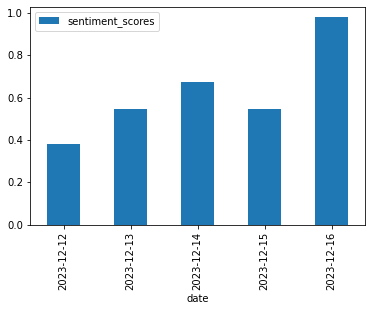

In [100]:
plt.figure(figsize = (10,8))
mean_df = df.groupby(['date']).mean()
mean_df.plot(kind = 'bar')
plt.show()

In [148]:
# Final data table
data.describe()

,Open,High,Low,Close,Volume,Adjusted Close,Tomorrow,Target,sma,ema,...,RSI,bollinger_high,bollinger_low,stochastic_oscillator,ATR,ichimoku_a,ichimoku_b,pivot_point,pivot_support,pivot_resistance
count,4866.000000,4866.000000,4866.000000,4866.000000,4.866000e+03,4866.000000,4865.000000,4866.000000,4855.000000,4855.000000,...,4853.000000,4847.000000,4847.000000,4853.000000,4866.000000,4841.000000,4866.000000,4866.000000,4866.000000,4866.000000
mean,41.629798,42.071177,41.206955,41.647284,1.187695e+08,41.647284,41.655331,0.523222,41.586742,41.586415,...,54.324281,43.851855,39.231572,57.284163,0.951720,41.564309,40.877381,41.641806,41.212434,42.076656
std,38.742014,39.184263,38.343796,38.769941,1.511614e+08,38.769941,38.769862,0.499512,38.641101,38.630083,...,12.583113,40.763743,36.391823,30.654241,1.020148,38.480323,38.012866,38.764604,38.348095,39.188257
min,2.470490,2.534002,2.390042,2.490913,1.584340e+05,2.490913,2.490913,0.000000,2.568020,2.549964,...,21.330543,2.827849,2.343683,0.000000,0.000000,2.807913,2.490914,2.493653,2.395522,2.525367
25%,12.857308,12.965652,12.715340,12.840931,2.847900e+07,12.840931,12.845602,0.000000,12.859746,12.899350,...,45.020771,13.641166,11.994072,30.243615,0.279052,12.869076,12.939499,12.831695,12.716315,12.971006
50%,26.537392,26.742038,26.336245,26.572046,6.119925e+07,26.572046,26.581520,1.000000,26.647125,26.696722,...,54.021869,27.505481,25.435898,61.387175,0.466421,26.731982,26.688477,26.540014,26.328514,26.751949
75%,57.501749,58.455125,57.111750,57.756124,1.466195e+08,57.756124,57.773998,1.000000,57.505896,57.562032,...,63.415639,60.833081,54.115375,86.043361,1.146190,58.047499,57.559376,57.644708,57.184876,58.433285
max,151.863495,152.100006,149.887497,150.709000,1.650833e+09,150.709000,150.709000,1.000000,148.977584,148.561468,...,90.929431,153.767702,144.538475,100.000000,4.788934,146.443378,144.299255,150.563334,149.276662,151.879832


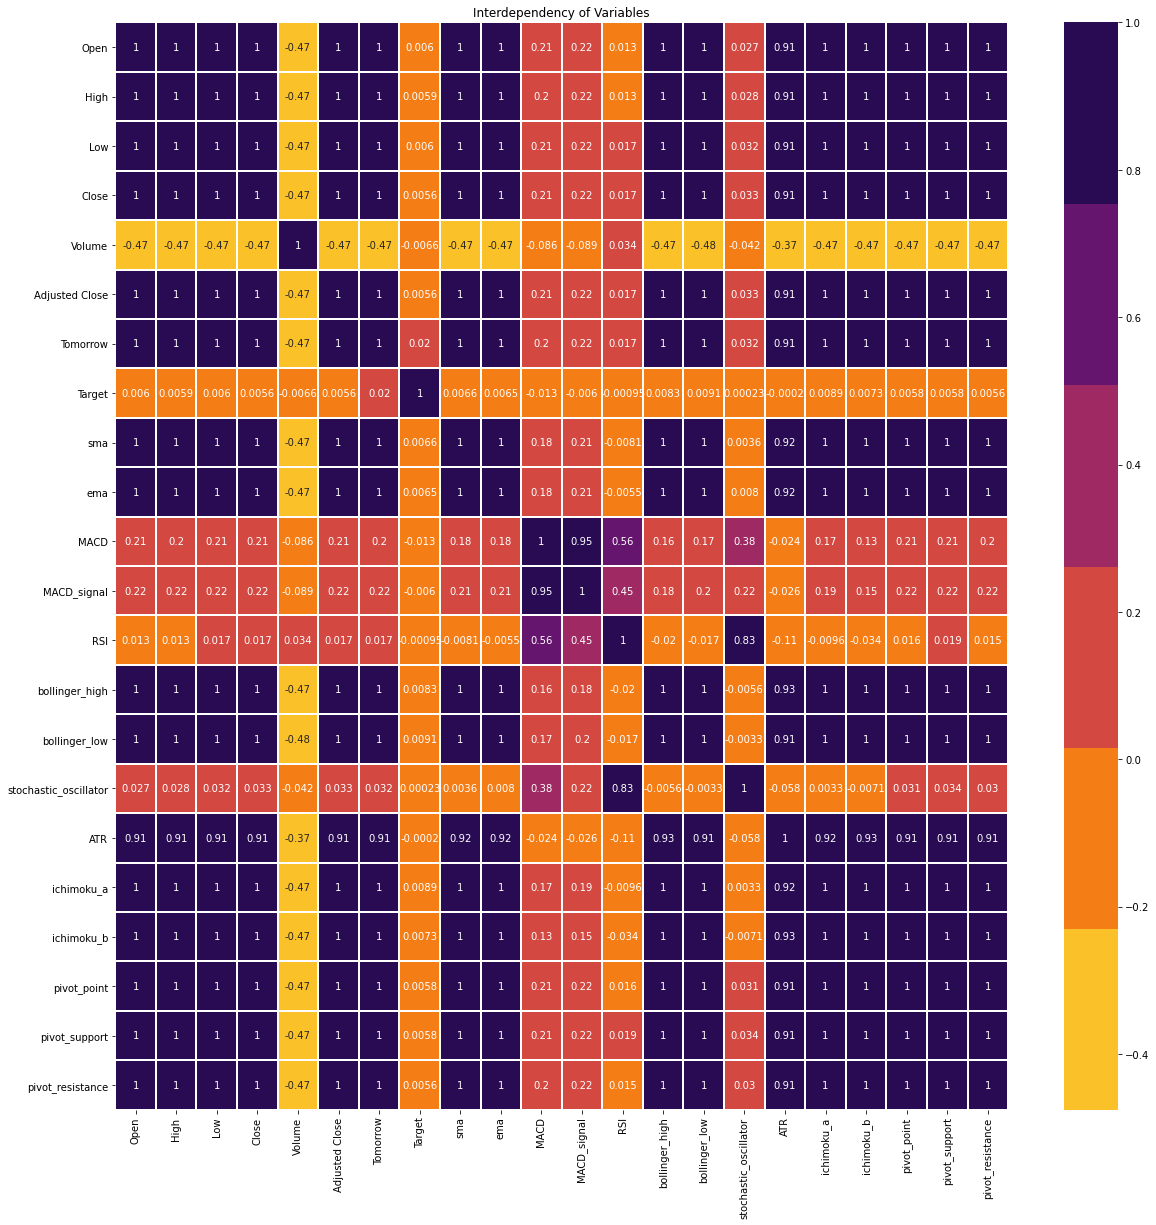

In [150]:
correlation = data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation,annot=True,
            cmap=sns.color_palette("inferno_r"),
            linewidth=1,edgecolor="k")
plt.title("Interdependency of Variables")
plt.show()

# 3. Pre-process Data

In [181]:
# training and testing split
X = np.array(data.drop(columns=['Adjusted Close'])) # features
y = np.array(data['Adjusted Close']) # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [185]:
y_train

array([ 26.62839127, 113.08399963,  22.23316574, ...,  40.30350113,
        60.25500107,  10.79329395])

In [183]:
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)

X_train.shape:  (3865, 21)
y_train.shape:  (3865,)


In [225]:
# Variables to hold results for all ML models
max_accuracy = []

# 4. Linear Regression Models

**4.1 Linear Regression + L1 Regularization**

In [337]:
alpha = [0.0001, 0.001, 0.01, 0.05, 0.1]
accuracy = []
validation_scores = []
train_scores = []
test_scores = []
y_preds = []

In [331]:
def linearRegression(a , X_train, y_train, X_test, y_test):
    # Create an object of logistic regression model using linear_model.
  
    reg = linear_model.Lasso(alpha= a, warm_start=True,  max_iter = 5000)
    reg.fit(X_train, y_train)
    
    # Calculating yhat for train and test
    y_pred = reg.predict(X_test)
    y_preds.append(y_pred)
    
    # Calculating accuracy
    accuracy_val = r2_score(y_test, y_pred)
    validation_score = np.mean(cross_val_score(reg, X_train, y_train, cv=5))
    train_score = reg.score(X_train, y_train)
    test_score = reg.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    validation_scores.append(validation_score)
    accuracy.append(accuracy_val)
    
    # Printing values 
    print("For alpha = %f" % a)
    print("Accuracy on test data = %f" % accuracy_val)
    print("Validation Score = %f" % validation_score)
    print("Train Score = %f" % train_score)
    print("Test Score = %f" % test_score)

In [335]:
for i in alpha:
    linearRegression(i, X_train, y_train, X_test, y_test)  
    print()

For alpha = 0.000100
Accuracy on test data = 0.999944
Validation Score = 0.999945
Train Score = 0.999947
Test Score = 0.999944

For alpha = 0.001000
Accuracy on test data = 0.999955
Validation Score = 0.999956
Train Score = 0.999957
Test Score = 0.999955

For alpha = 0.010000
Accuracy on test data = 0.999964
Validation Score = 0.999965
Train Score = 0.999966
Test Score = 0.999964

For alpha = 0.050000
Accuracy on test data = 0.999962
Validation Score = 0.999963
Train Score = 0.999964
Test Score = 0.999962

For alpha = 0.100000
Accuracy on test data = 0.999956
Validation Score = 0.999958
Train Score = 0.999959
Test Score = 0.999956



**4.2 Hyperparameter Optimization - Lasso**

In [334]:
reg = linear_model.Lasso(warm_start=True,  max_iter = 5000)
grid = GridSearchCV(estimator = reg, param_grid= dict(alpha= alpha), scoring= 'r2', cv= 5)
grid.fit(X_train, y_train)
print(f"Best Alpha: {grid.best_estimator_.alpha}")

# Predict using the best model
y_pred = grid.predict(X_test)

# Calculate accuracy and scores
accuracy_val = r2_score(y_test, y_pred)
train_score = grid.score(X_train, y_train)
test_score = grid.score(X_test, y_test)

# Print values
print("Accuracy on test data:", accuracy_val)
print("Train Score:", train_score)
print("Test Score:", test_score)


Best Alpha: 0.01
Accuracy on test data: 0.9999641520932748
Train Score: 0.9999657170977782
Test Score: 0.9999641520932748


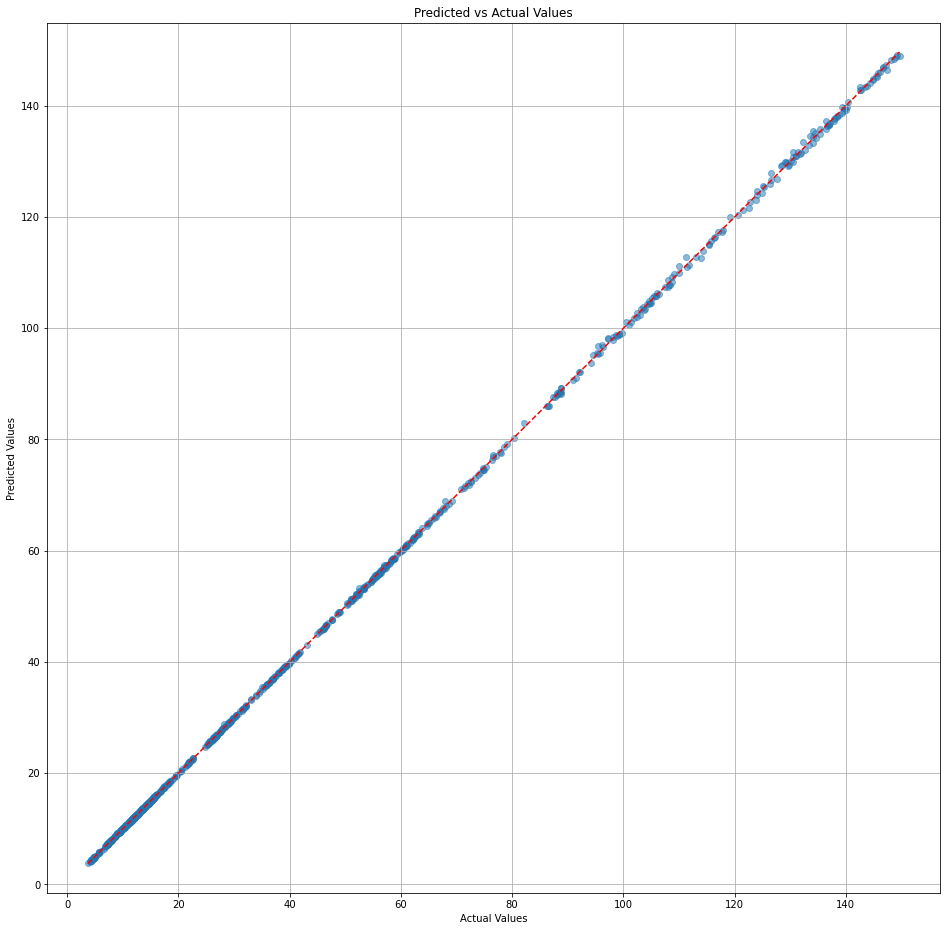

In [324]:
import matplotlib.pyplot as plt
y_pred = y_preds[2]
plt.figure(figsize=(16, 16))
plt.scatter(y_test, y_pred, alpha=0.5)  # plot the predictions vs the actual values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # plot a 45-degree reference line

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.grid(True)
plt.axis('equal')  # Set equal scaling by changing axis limits
plt.show()

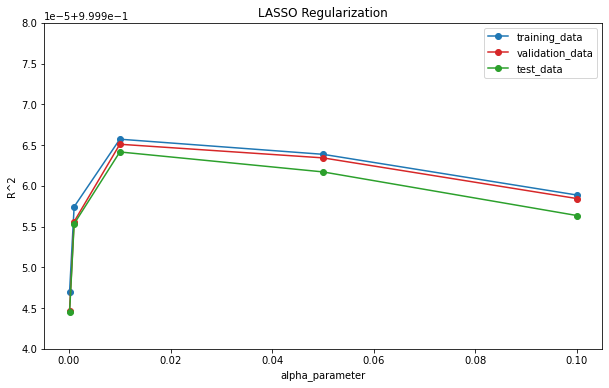

In [301]:
plt.figure(figsize=(10, 6))
plt.ylim(0.99994, 0.99998)
plt.plot(alpha, train_scores, label='training_data', marker='o', linestyle='-', color = "tab:blue")
plt.plot(alpha, validation_scores, label='validation_data', marker='o', linestyle='-', color = "tab:red")
plt.plot(alpha, test_scores, label='test_data', marker='o', linestyle='-', color = "tab:green")

plt.xlabel('alpha_parameter')
plt.ylabel('R^2')
plt.title('LASSO Regularization')
plt.legend()
plt.show()

**4.3 Linear Regression + L2 Regularization**

In [338]:
alpha = [0.0001, 0.001, 0.01, 0.05, 0.1]
accuracy = []
validation_scores = []
train_scores = []
test_scores = []
y_preds = []

In [339]:
def linearRegression(a , X_train, y_train, X_test, y_test):
    # Create an object of logistic regression model using linear_model.
  
    reg = linear_model.Ridge(alpha= a, solver= 'saga', random_state = 42, max_iter = 5000)
    reg.fit(X_train, y_train)
    
    # Calculating yhat for train and test
    y_pred = reg.predict(X_test)
    y_preds.append(y_pred)
    
    # Calculating accuracy
    accuracy_val = r2_score(y_test, y_pred)
    validation_score = np.mean(cross_val_score(reg, X_train, y_train, cv=5))
    train_score = reg.score(X_train, y_train)
    test_score = reg.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    validation_scores.append(validation_score)
    accuracy.append(accuracy_val)
    
    # Printing values 
    print("For alpha = %f" % a)
    print("Accuracy on test data = %f" % accuracy_val)
    print("Validation Score = %f" % validation_score)
    print("Train Score = %f" % train_score)
    print("Test Score = %f" % test_score)

In [340]:
for i in alpha:
    linearRegression(i, X_train, y_train, X_test, y_test)  
    print()

For alpha = 0.000100
Accuracy on test data = 0.999991
Validation Score = 0.999988
Train Score = 0.999991
Test Score = 0.999991

For alpha = 0.001000
Accuracy on test data = 0.999990
Validation Score = 0.999988
Train Score = 0.999991
Test Score = 0.999990

For alpha = 0.010000
Accuracy on test data = 0.999990
Validation Score = 0.999988
Train Score = 0.999991
Test Score = 0.999990

For alpha = 0.050000
Accuracy on test data = 0.999989
Validation Score = 0.999987
Train Score = 0.999990
Test Score = 0.999989

For alpha = 0.100000
Accuracy on test data = 0.999988
Validation Score = 0.999986
Train Score = 0.999989
Test Score = 0.999988



In [342]:
reg = linear_model.Ridge(solver= 'saga', random_state = 42, max_iter = 5000)
grid = GridSearchCV(estimator = reg, param_grid= dict(alpha= alpha), scoring= 'r2', cv= 5)
grid.fit(X_train, y_train)
print(f"Best Alpha: {grid.best_estimator_.alpha}")

# Predict using the best model
y_pred = grid.predict(X_test)

# Calculate accuracy and scores
accuracy_val = r2_score(y_test, y_pred)
train_score = grid.score(X_train, y_train)
test_score = grid.score(X_test, y_test)

# Print values
print("Accuracy on test data:", accuracy_val)
print("Train Score:", train_score)
print("Test Score:", test_score)

Best Alpha: 0.0001
Accuracy on test data: 0.9999905112789913
Train Score: 0.9999912028514404
Test Score: 0.9999905112789913


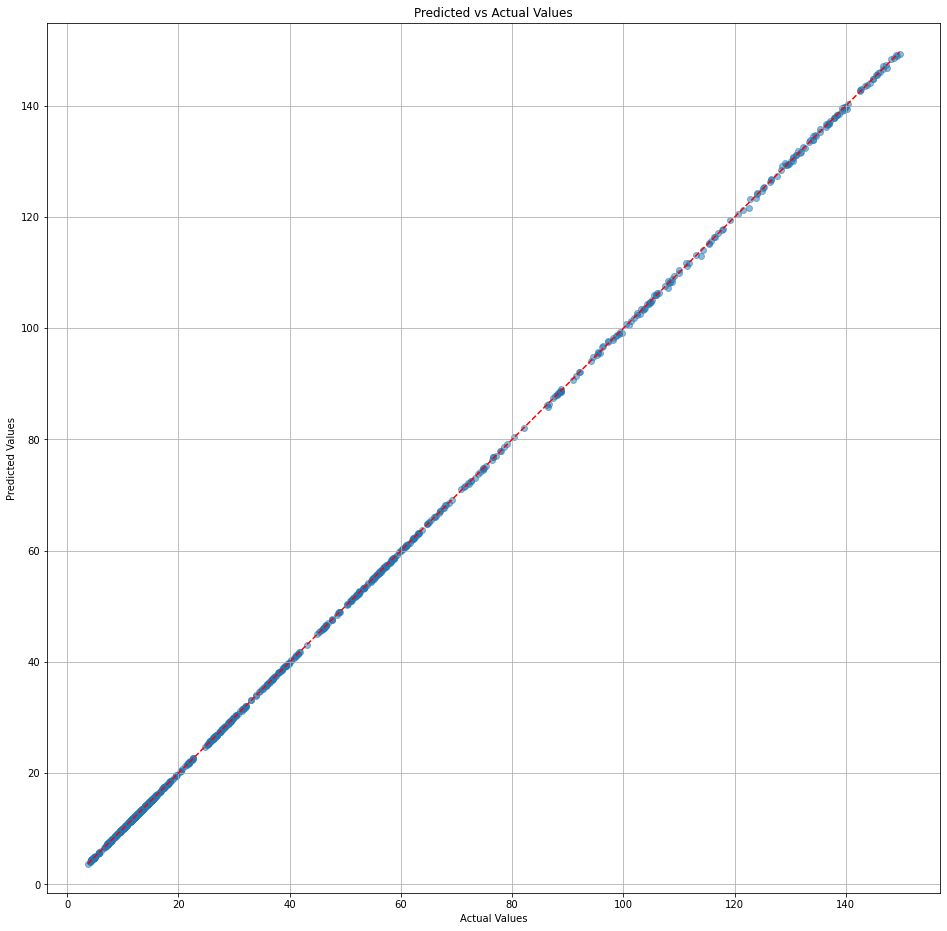

In [344]:
y_pred = y_preds[2]
plt.figure(figsize=(16, 16))
plt.scatter(y_test, y_pred, alpha=0.5)  # plot the predictions vs the actual values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # plot a 45-degree reference line

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.grid(True)
plt.axis('equal')  # Set equal scaling by changing axis limits
plt.show()

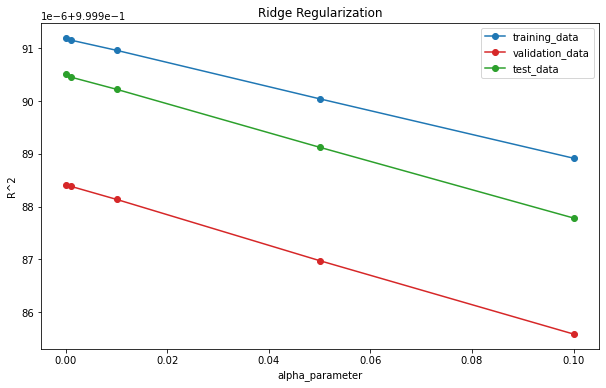

In [347]:
plt.figure(figsize=(10, 6))
#plt.ylim(0.99994, 0.99998)
plt.plot(alpha, train_scores, label='training_data', marker='o', linestyle='-', color = "tab:blue")
plt.plot(alpha, validation_scores, label='validation_data', marker='o', linestyle='-', color = "tab:red")
plt.plot(alpha, test_scores, label='test_data', marker='o', linestyle='-', color = "tab:green")

plt.xlabel('alpha_parameter')
plt.ylabel('R^2')
plt.title('Ridge Regularization')
plt.legend()
plt.show()

In [ ]:
# random forest -> feature selection + sentiment analyis